# Added mass - located right

In [1]:
using ViscousFlow

In [23]:
using Plots
using DelimitedFiles
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [3]:
using LinearAlgebra

### First, some generalities

In [4]:
𝐞₁ = [1;0];
𝐞₂ = [0;1];

#### First create a grid and a Laplacian operator on it

In [33]:
nx = 500; ny = 85;
Lx = 12.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));

In [34]:
L = plan_laplacian(size(w),with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 500, ny = 85) grid with spacing 1.0

#### Now create a circular shape, with discrete points and associated regularization and interpolation operator

In [47]:
n = 100

R = 0.5
body = Ellipse(R,R,n)

# Find the minimum arc length
ds = minimum(Bodies.dlength(body))

# Move the ellipse
xc = 11.0; yc = 1.0
T = RigidTransform((xc,yc),0.0)
T(body)

# Area of the ellipse
𝒱 = π*body.a*body.b

0.7853981633974483

#### Set up the coordinates and other useful vectors

In [48]:
X = VectorData(body.x,body.y)
f = ScalarData(X);

In [49]:
println("Ratio of arc spacing to cell size = ",ds/dx)

Ratio of arc spacing to cell size = 1.303546501742315


In [50]:
E = Regularize(X,dx;issymmetric=true)
Hmat,Emat = RegularizationMatrix(E,f,w);

#### And now create the saddle-point system

In [51]:
L⁻¹(w::T) where {T} = L\w
PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with 100 constraints and
   State of type Nodes{Dual,500,85}
   Force of type ScalarData{100}


#### Create some data structures for general use

In [52]:
ψb = ScalarData(X)
w = Nodes(Dual,(nx,ny))
ψ = Nodes(Dual,w);

### Solve flow generated by a translating cylinder

In [53]:
U = 0;
V = 1;

In [54]:
ψb .= U*(body.y .- body.cent[2]) - V*(body.x .- body.cent[1])
@time ψ,f = PS\(w,ψb)

  0.037022 seconds (141 allocations: 2.938 MiB)


(Dual nodes in a (nx = 500, ny = 85) cell grid
  Number of Dual nodes: (nx = 500, ny = 85), [-0.0648404, -0.0647124, -0.0643291, -0.0636919, -0.0628033, -0.0616668, -0.060287, -0.0586693, -0.05682, -0.0547465  …  -0.0524569, -0.0547465, -0.05682, -0.0586693, -0.060287, -0.0616668, -0.0628033, -0.0636919, -0.0643291, -0.0647124])

#### Plot the result

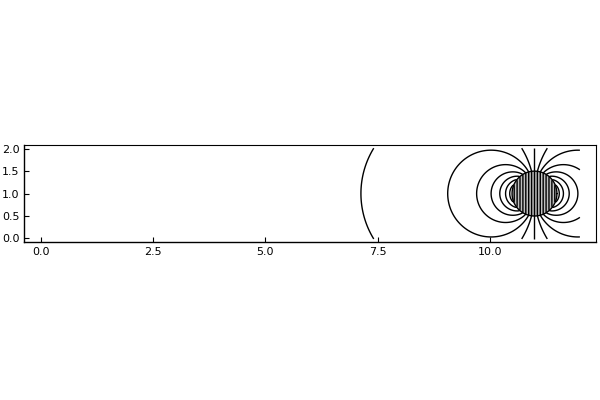

In [55]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ,linecolor=:black,levels=range(-1,1,length=31))
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

#### Check added mass coefficient

In [56]:
"""
integrate(f::Function,xmin::Real,xmax::Real,N::Int,name::String) -> Real
Integrate the function `f` between the limits `xmin` to `xmax` with `N` intervals using either the `"trapezoidal"` or `"simpson"` rule specified in `name`. The solution is returned as a Real value.
"""
function surface_integrate(body::Body{N},integrand::Array{Float64,1}) where {N}
    func = Array{Float64,1}(undef, N+1)
    func[1:end-1] .= integrand
    func[end] = integrand[1]
    s = sum(Bodies.dlength(body).*(func[1:end-1] + func[2:end]))
    return s
end

surface_integrate

In [64]:
integrand_x = (f./Bodies.dlength(body)).*(body.y);
integrand_y = -(f./Bodies.dlength(body)).*(body.x);
# writedlm("integrand_x_one_body.csv",integrand_x, ',')
sum(integrand_x)

-1.3322676295501878e-15

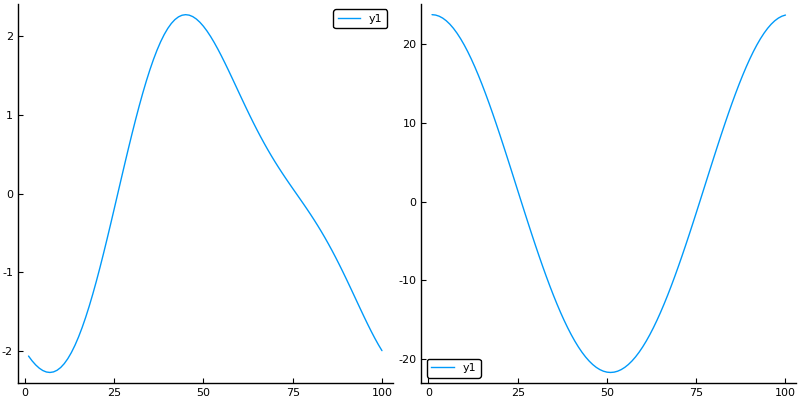

In [58]:
p1 = plot(integrand_x)
p2 = plot(integrand_y)
p3 = plot(p1,p2,layout=(1,2),size=[800,400])

In [59]:
# P¹ = -𝒱*𝐞₁ + 0.5*[surface_integrate(body,integrand_x);surface_integrate(body,integrand_y)]
P² = -𝒱*𝐞₂ + 0.5*[surface_integrate(body,integrand_x);surface_integrate(body,integrand_y)]

2-element Array{Float64,1}:
 -9.71445146547012e-17
  0.8356106107428136  

In [60]:
M₁₁ = dot(P¹,𝐞₁)

UndefVarError: UndefVarError: P¹ not defined

Compare the generated vortex sheet `f/ds` with the exact solution

In [61]:
θ = range(0,2π,length=n+1)
fex = 2*sin.(θ[1:n]);
errinf = LinearAlgebra.norm(f./ds-fex,Inf)

2.873883749969381

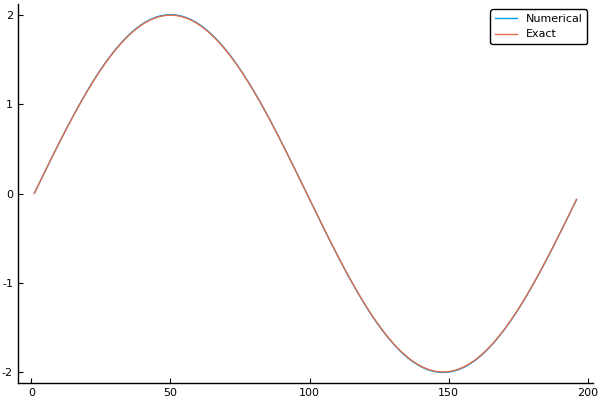

In [38]:
plot(f./ds,label="Numerical")
plot!(fex,label="Exact")